**Project Topic**

In this project, I implemented Long Short Term Memory (LSTM) to perform Natural Language Processing (NLP) on tweets. My code was trained and validated to detect whether a given tweet is indicative of a natural disaster or not. I experimented with different dropout rates and found I was able to achieve a ~92% accuracy on training data and a ~75% accuracy on testing data.

**Data**

First, I important relevant Python libraries and imported the data. The training data has 7613 rows for that number of tweets. The testing data has 3263 rows. I printed some of the columns to get a sense for different variables.

In [239]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from scipy import stats
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.preprocessing.sequence import pad_sequences

In [240]:
train_df = pd.read_csv("nlp-getting-started/train.csv")
val_df = pd.read_csv("nlp-getting-started/test.csv")

In [241]:
train_df = train_df.drop(columns=['keyword','location'])
val_df = val_df.drop(columns=['keyword','location'])

**Exploratory Data Analysis**

After visualizing a subset of the data, I looked at to what extent it would need to be cleaned and pre-processed. Since the data set comes from a Kaggle competition, it was already in relatively good condition. There weren't any totally invalid tweets that I just needed to delete entirely.

My pre-processing methodology comes directly from Reference 6, which is an example notebook for a different data science application but I found has a good pre-processing algorithm that would be applicable to this natural disaster natural language processing project.

To make it easier for the models to digest, I first removed a variety of characters.

Next, I split the data into training and testing sets. There is still the separate testing/validation set for the Kaggle submission, but this intermediate testing set derived from the training data helsp with assessing the performance of my model for each training epoch. 

Finally, I tokenized the text such that it now contains counts for the 4,000 most common words used across all of the tweets.

In [187]:
print(val_df)

         id                                               text
0         0                 Just happened a terrible car crash
1         2  Heard about #earthquake is different cities, s...
2         3  there is a forest fire at spot pond, geese are...
3         9           Apocalypse lighting. #Spokane #wildfires
4        11      Typhoon Soudelor kills 28 in China and Taiwan
...     ...                                                ...
3258  10861  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259  10865  Storm in RI worse than last hurricane. My city...
3260  10868  Green Line derailment in Chicago http://t.co/U...
3261  10874  MEG issues Hazardous Weather Outlook (HWO) htt...
3262  10875  #CityofCalgary has activated its Municipal Eme...

[3263 rows x 2 columns]


In [238]:
print(train_df)

         id                                               text  target
0         1  our deeds are the reason of this earthquake ma...       1
1         4              forest fire near la ronge sask canada       1
2         5  all residents asked to shelter in place are be...       1
3         6  13000 people receive wildfires evacuation orde...       1
4         7  just got sent this photo from ruby alaska as s...       1
...     ...                                                ...     ...
7608  10869  two giant cranes holding a bridge collapse int...       1
7609  10870  aria ahrary thetawniest the out of control wil...       1
7610  10871              m194 0104 utc 5km s of volcano hawaii       1
7611  10872  police investigating after an e bike collided ...       1
7612  10873  the latest more homes razed by northern califo...       1

[7613 rows x 3 columns]


In [205]:
def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

train_df['text'] = train_df['text'].apply(lambda x: process(x))
val_df['text'] = val_df['text'].apply(lambda x: process(x))                       

In [189]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [190]:
train_df[train_df["target"] == 0]["text"].values[1]

'i love fruits'

In [191]:
train_df[train_df["target"] == 1]["text"].values[1]

'forest fire near la ronge sask canada'

In [235]:
train_rev, test_rev, train_sent, test_sent = train_test_split(train_df['text'], train_df['target'], test_size=0.1, random_state=42)

In [207]:
val_rev = val_df['text']

In [ ]:
dict_size = 4000
tokenizer = Tokenizer(num_words=dict_size)
tokenizer.fit_on_texts(train_df['text'])

In [195]:
train_rev_tokens = tokenizer.texts_to_sequences(train_rev)
test_rev_tokens = tokenizer.texts_to_sequences(test_rev)
seq_lengths =  np.array([len(sequence) for sequence in train_rev_tokens])

upper_bound = int(np.mean(seq_lengths) + 2 * np.std(seq_lengths))
percentage = stats.percentileofscore(seq_lengths, upper_bound)

In [236]:
train_rev_pad = pad_sequences(train_rev_tokens, maxlen=upper_bound)
test_rev_pad = pad_sequences(test_rev_tokens, maxlen=upper_bound)

In [237]:
print(train_rev_pad.size)

150722


**Model Architecture**

I also followed Reference 6 (Kaggle project for a different NLP application) for the model architecture portion of this report. Using Keras/Tensorflow, I implemented LSTM with a variable dropout rate. I was curious how the dropout rate would affect the learning rate as well as the end accuracies on both the training and testing data sets. My hypothesis was that higher dropout rates would reduce overfitting. I built and trained models with dropout rates of 0.6, 0.7, 0.8, and 0.9. I trained all of those models to 20 epochs to make sure I wasn't stopping the training early on any of them.

In [233]:
output_dim = 14
units_lstm = 16
r = 0.6

model2 = Sequential()
model2.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model2.add(LSTM(units_lstm))
model2.add(Dropout(r))
model2.add(Dense(1, activation='sigmoid'))

In [234]:
validation_split = 0.3
batch_size = 200
epochs = 20

model2.compile(optimizer='adam', loss='bce', metrics='accuracy')

fitted2 = model2.fit(train_rev_pad, train_sent, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)



Epoch 1/20
24/24 [==============================] - 14s 423ms/step - loss: 0.6845 - accuracy: 0.5748 - val_loss: 0.6768 - val_accuracy: 0.5593
Epoch 2/20
24/24 [==============================] - 5s 211ms/step - loss: 0.6617 - accuracy: 0.5771 - val_loss: 0.6518 - val_accuracy: 0.5681
Epoch 3/20
24/24 [==============================] - 3s 136ms/step - loss: 0.6130 - accuracy: 0.6653 - val_loss: 0.5873 - val_accuracy: 0.6848
Epoch 4/20
24/24 [==============================] - 3s 118ms/step - loss: 0.5230 - accuracy: 0.7758 - val_loss: 0.5348 - val_accuracy: 0.7748
Epoch 5/20
24/24 [==============================] - 3s 111ms/step - loss: 0.4624 - accuracy: 0.8181 - val_loss: 0.5088 - val_accuracy: 0.7690
Epoch 6/20
24/24 [==============================] - 1s 48ms/step - loss: 0.4073 - accuracy: 0.8430 - val_loss: 0.4986 - val_accuracy: 0.7763
Epoch 7/20
24/24 [==============================] - 1s 45ms/step - loss: 0.3683 - accuracy: 0.8617 - val_loss: 0.5081 - val_accuracy: 0.7763
Epoch 8

In [231]:
output_dim = 14
units_lstm = 16
r = 0.7

model1 = Sequential()
model1.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model1.add(LSTM(units_lstm))
model1.add(Dropout(r))
model1.add(Dense(1, activation='sigmoid'))

In [232]:
validation_split = 0.3
batch_size = 200
epochs = 20

model1.compile(optimizer='adam', loss='bce', metrics='accuracy')

fitted1 = model1.fit(train_rev_pad, train_sent, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)



Epoch 1/20
24/24 [==============================] - 13s 384ms/step - loss: 0.6866 - accuracy: 0.5575 - val_loss: 0.6802 - val_accuracy: 0.5593
Epoch 2/20
24/24 [==============================] - 3s 135ms/step - loss: 0.6696 - accuracy: 0.5752 - val_loss: 0.6635 - val_accuracy: 0.5593
Epoch 3/20
24/24 [==============================] - 4s 160ms/step - loss: 0.6368 - accuracy: 0.6171 - val_loss: 0.6160 - val_accuracy: 0.6892
Epoch 4/20
24/24 [==============================] - 3s 128ms/step - loss: 0.5655 - accuracy: 0.7383 - val_loss: 0.5632 - val_accuracy: 0.7719
Epoch 5/20
24/24 [==============================] - 3s 105ms/step - loss: 0.5033 - accuracy: 0.7998 - val_loss: 0.5362 - val_accuracy: 0.7612
Epoch 6/20
24/24 [==============================] - 3s 111ms/step - loss: 0.4516 - accuracy: 0.8269 - val_loss: 0.5190 - val_accuracy: 0.7738
Epoch 7/20
24/24 [==============================] - 2s 73ms/step - loss: 0.4054 - accuracy: 0.8488 - val_loss: 0.5178 - val_accuracy: 0.7724
Epoch 

In [226]:
output_dim = 14
units_lstm = 16
r = 0.9

model0 = Sequential()
model0.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model0.add(LSTM(units_lstm))
model0.add(Dropout(r))
model0.add(Dense(1, activation='sigmoid'))

In [227]:
validation_split = 0.3
batch_size = 200
epochs = 20

model0.compile(optimizer='adam', loss='bce', metrics='accuracy')

fitted0 = model0.fit(train_rev_pad, train_sent, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)



Epoch 1/20
24/24 [==============================] - 12s 350ms/step - loss: 0.6890 - accuracy: 0.5572 - val_loss: 0.6847 - val_accuracy: 0.5593
Epoch 2/20
24/24 [==============================] - 4s 152ms/step - loss: 0.6770 - accuracy: 0.5754 - val_loss: 0.6743 - val_accuracy: 0.5593
Epoch 3/20
24/24 [==============================] - 3s 141ms/step - loss: 0.6668 - accuracy: 0.5977 - val_loss: 0.6573 - val_accuracy: 0.5978
Epoch 4/20
24/24 [==============================] - 3s 111ms/step - loss: 0.6360 - accuracy: 0.6425 - val_loss: 0.6183 - val_accuracy: 0.7111
Epoch 5/20
24/24 [==============================] - 2s 89ms/step - loss: 0.5820 - accuracy: 0.7220 - val_loss: 0.5614 - val_accuracy: 0.7568
Epoch 6/20
24/24 [==============================] - 3s 118ms/step - loss: 0.5383 - accuracy: 0.7610 - val_loss: 0.5306 - val_accuracy: 0.7665
Epoch 7/20
24/24 [==============================] - 3s 136ms/step - loss: 0.4959 - accuracy: 0.7800 - val_loss: 0.5063 - val_accuracy: 0.7738
Epoch 

In [199]:
output_dim = 14
units_lstm = 16
r = 0.8

model = Sequential()
model.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model.add(LSTM(units_lstm))
model.add(Dropout(r))
model.add(Dense(1, activation='sigmoid'))

In [200]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 22, 14)            28000     
                                                                 
 lstm_12 (LSTM)              (None, 16)                1984      
                                                                 
 dropout_12 (Dropout)        (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 30001 (117.19 KB)
Trainable params: 30001 (117.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [202]:
validation_split = 0.3
batch_size = 200
epochs = 20

model.compile(optimizer='adam', loss='bce', metrics='accuracy')

fitted = model.fit(train_rev_pad, train_sent, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)



Epoch 1/20
24/24 [==============================] - 19s 371ms/step - loss: 0.3906 - accuracy: 0.8442 - val_loss: 0.5038 - val_accuracy: 0.7797
Epoch 2/20
24/24 [==============================] - 3s 123ms/step - loss: 0.3719 - accuracy: 0.8567 - val_loss: 0.5100 - val_accuracy: 0.7772
Epoch 3/20
24/24 [==============================] - 2s 97ms/step - loss: 0.3536 - accuracy: 0.8680 - val_loss: 0.5260 - val_accuracy: 0.7738
Epoch 4/20
24/24 [==============================] - 3s 106ms/step - loss: 0.3411 - accuracy: 0.8690 - val_loss: 0.5319 - val_accuracy: 0.7665
Epoch 5/20
24/24 [==============================] - 2s 95ms/step - loss: 0.3342 - accuracy: 0.8767 - val_loss: 0.5404 - val_accuracy: 0.7568
Epoch 6/20
24/24 [==============================] - 3s 111ms/step - loss: 0.3201 - accuracy: 0.8824 - val_loss: 0.5440 - val_accuracy: 0.7695
Epoch 7/20
24/24 [==============================] - 2s 100ms/step - loss: 0.3106 - accuracy: 0.8868 - val_loss: 0.5523 - val_accuracy: 0.7656
Epoch 8

**Results and Analysis**

The highest dropout rate of 0.9 performed the worst. The other three dropout rates yielded similar results: accuracy on the order of 92% and validation accuracy on the order of 75%. I picked the model with the dropout rate of 0.8 as the one I would use to perform the predictions for the Kaggle competition because in the event that the extent of overfitting may not have been captured by the 20 epochs of training with validation, I thought that the higher dropout rate would give me the best result in with the competition data set.

I created a confusion matrix to better visualize the performance of my model and see if it was biased in any way. Overall, I deemed the results to be relatively well balanced. While there were more true non-disasters than actual disaster, the number of incorrect predicitons in either case were very close - 103 vs. 97. This indicates to me that the model isn't defaulting to automatically picking the more common outcome.

Finally, I used the model.predict() function to perfor my predictons on the Kaggle data set. After uploading to the Kaggle website, I found that scored an accuracy of 76.8%, putting me in 902nd place.

In [ ]:
test_pred =  model.evaluate(test_rev_pad, test_sent)

24/24 [==============================] - 1s 29ms/step


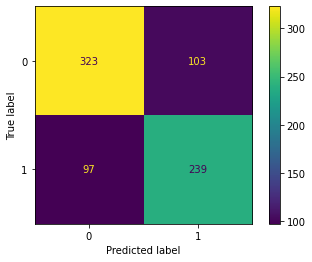

In [242]:
predictions = np.round(model.predict(test_rev_pad))
cf_matrix = confusion_matrix(test_sent, predictions)


disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()

In this section, do all the same pre-processing steps to the validation data that will be used to perform predictions on the Kaggle competition data set.

In [210]:
val_df['text'] = val_df['text'].apply(lambda x: process(x))

val_rev = val_df['text']
print(val_rev)
print(val_rev.size)

val_rev_tokens = tokenizer.texts_to_sequences(val_rev)

val_rev_pad = pad_sequences(val_rev_tokens, maxlen=upper_bound)
print(val_rev_pad.size)

0                      just happened a terrible car crash
1       heard about earthquake is different cities sta...
2       there is a forest fire at spot pond geese are ...
3                   apocalypse lighting spokane wildfires
4           typhoon soudelor kills 28 in china and taiwan
                              ...                        
3258    earthquake safety los angeles safety fasteners...
3259    storm in ri worse than last hurricane my city ...
3260                     green line derailment in chicago
3261             meg issues hazardous weather outlook hwo
3262    cityofcalgary has activated its municipal emer...
Name: text, Length: 3263, dtype: object
3263
71786


In [222]:
predictions = model.predict(val_rev_pad)
print(len(predictions))
print(predictions)

102/102 [==============================] - 1s 8ms/step
3263
[[0.0900268 ]
 [0.943518  ]
 [0.99533635]
 ...
 [0.9827639 ]
 [0.8832012 ]
 [0.91683143]]


In [224]:
#the predict_generator output is a list of lists, where the elements are the probabilities of each class. 
#This code turns it into a final predction value by rounding (0 or 1 since there are two classificaiton categories, 
#then writes it to a csv that I upload to Kaggle
pc = np.round_(predictions,decimals=0)
print(pc.size)
print(pc)
pc = pd.DataFrame(pc)
pc.to_csv('submission.csv')

3263
[[0.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


 **Conclusion**
 
In this project, I implemented LSTM to classify whether tweets are or are not indicative of a natural disaster. This kind of project could be useful for emergency response authorities and NGOs to determine where to allocate resources and what to respond to real-time.

I experimented with modifying the dropout rate in hyperparameter tuning. I found that a dropout rate as high as 0.9 significantly impacted accuracy, but rates ranging from 0.6 to 0.8 yielded similar outcomes after 20 epochs of training.

For the Kaggle competition, I was able to achieve a 76.8% accuarcy. This put me in the middle of the pack. If I were to continue this project and try to improve my score, I would experiment with models that contain multiple layers and different activation functions.

**References:**
- https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial/notebook
-- This is an example notebook for this project. I used an entirely different ML algorithm for the actual training, but used the example code for importing in the data
- https://keras.io/examples/nlp/multi_label_classification/
- https://github.com/keras-team/keras/blob/master/keras/datasets/imdb.py
- https://stackoverflow.com/questions/49146529/how-keras-imdb-dataset-data-is-preprocessed#:~:text=The%20words%20in%20the%20imdb,it%20will%20download%20the%20dataset.&text=numpy%20arrays%20x_train%2C%20y_train%2C%20x_test,returned%20by%20the%20load_data%20function.
- https://keras.io/examples/nlp/bidirectional_lstm_imdb/
- https://www.kaggle.com/code/rafaeltiedra/step-by-step-imdb-sentiment-analysis
-- This is an example notebook for a different project, but since it was also NLP, I followed many of the methods as well as made my own additions/changes
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
- https://datascience.stackexchange.com/questions/32194/how-to-predict-class-label-from-class-probability-given-by-predict-generator-for
- https://keras.io/api/layers/regularization_layers/dropout/